<a href="https://colab.research.google.com/github/rajgit-123/MyProject/blob/master/Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution vs Cross Correlation

 Convolution is a mathematical operation that plays a pivotal role in a wide range of applications, from sharpening the edges of digital images to powering the convolutional neural networks (CNNs) that have revolutionized computer vision and machine learning.
 There is however a slight misnomer. In signal processing the word convolution actually refers to a different operation. In the continuous domain it is defined as the integral of the product of the two functions after one is reversed and shifted.
 $$ (f*g)(t) = ∫_{-∞}^{∞}f(τ)g(t-τ)dτ $$
 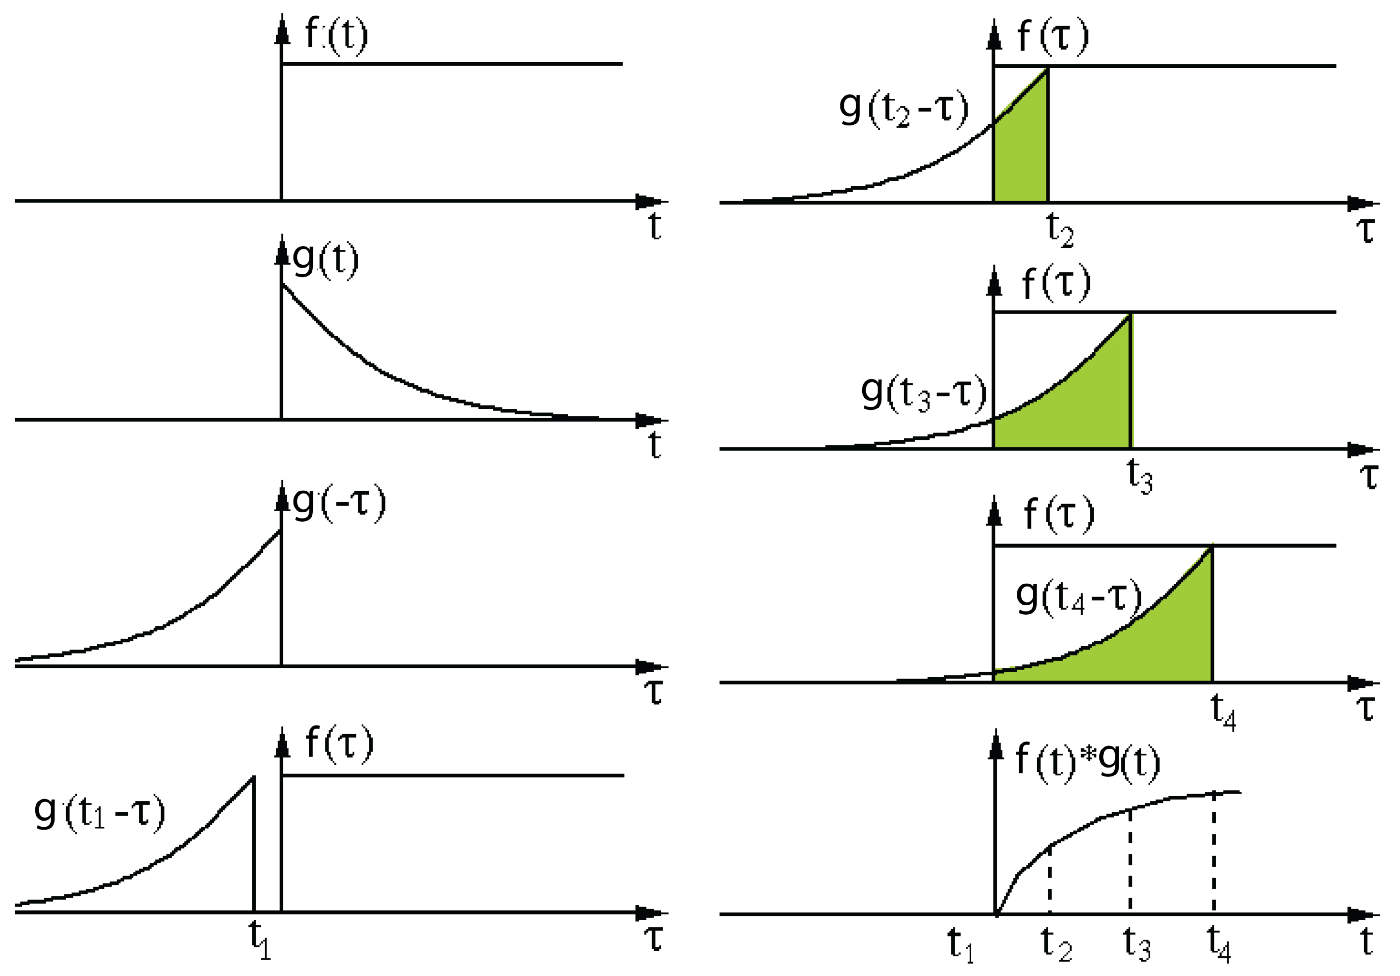

The difference in cross correlation is that the filter is not reversed and directly slides over the function $f$. In deep learning the function is not reversed and directly slides over the weights. This is fine because in a learning scenario the filters are learned so if the reversed function was the correct one after the learning process the filters would look like that

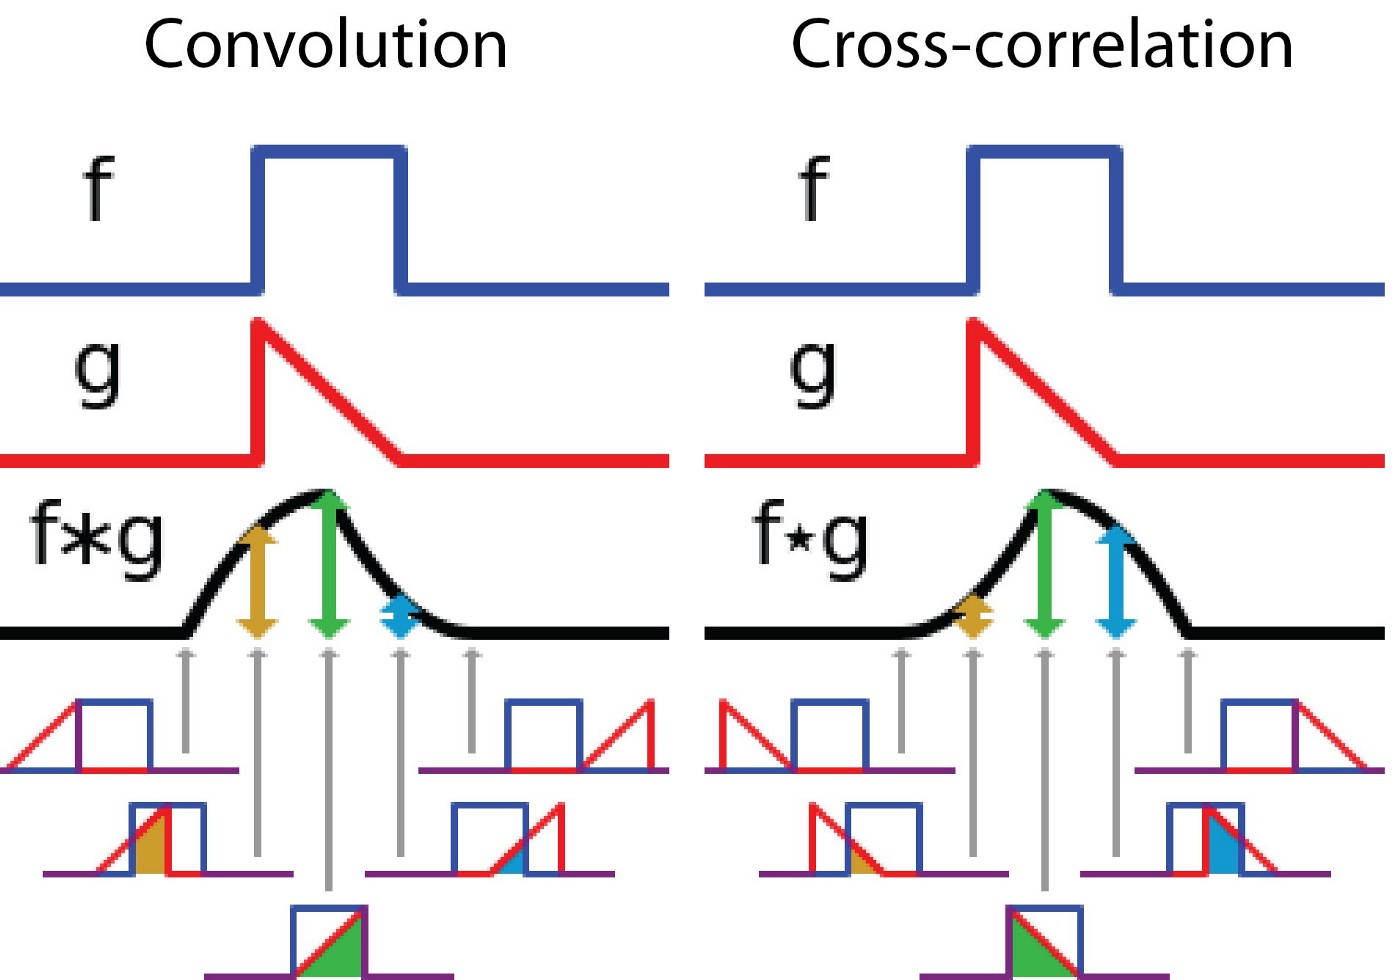

# The 2D Convolution

The purpose of doing convolution is to extract useful features from the input. In image processing, there is a wide range of different filters one could choose for convolution. Each type of filters helps to extract different aspects or features from the input image, e.g. horizontal / vertical / diagonal edges.

In Convolutional Neural Network, different features are extracted through convolution using filters whose weights are automatically learned during training. All these extracted features then are combined to make decisions.

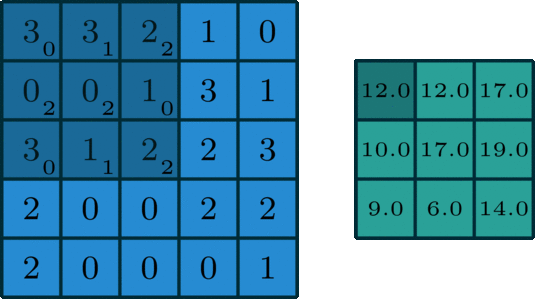


In Deep Learning, convolution is the element-wise multiplication and addition. For an image with 1 channel, the convolution is demonstrated in the figure below. Here the filter is a 3 x 3 matrix with element  $\begin{bmatrix}
  0 & 1 & 2\\
  2 & 2 & 0\\
  0 & 1 & 2
\end{bmatrix}$ . The filter is sliding through the input. At each position, it’s doing element-wise multiplication and addition. Each sliding position ends up with one number. The final output is then a 3 x 3 matrix.

As we all know an image is a 3 channel concept. So how does a filter act on a multi channel input?
<img src="https://archive.li/2RicS/77bf0a480af5f9dc8d98f8c61f5bfbb3373f4e34.gif" width="750" align="center">
<img src="https://archive.li/2RicS/77757a738f92ca921a2ec059d338a1ea94384c3b.gif" width="750" align="center">


We can think of this process as sliding a 3D filter matrix through the input layer. Notice that the input layer and the filter have the same depth (channel number = kernel number). The 3D filter moves only in 2-direction, height & width of the image (That’s why such operation is called as 2D convolution although a 3D filter is used to process 3D volumetric data). At each sliding position, we perform element-wise multiplication and addition, which results in a single number.

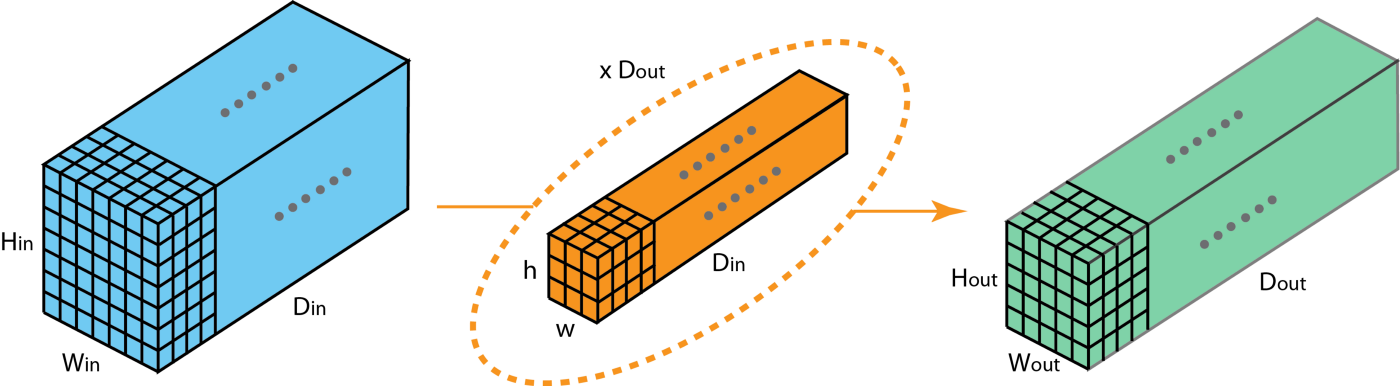

## So finally what is the convolution?
You're sliding a filter of size (h, w, Din) through an input of size (Hin, Win, Din) Dout number of times to get an output of size (Hout, Wout, Dout)

## Convolution

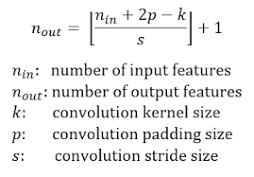

In [ ]:
n = [1, 2, 3, 4, 5, 6, 7]


In [ ]:
import torch
import torch.nn as nn
import numpy as np

class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride, name):
        super(CustomConv2d, self).__init__()
        self.F = out_channels
        self.K = kernel_size
        self.C = in_channels

        self.weights = nn.Parameter(torch.Tensor(self.F, self.C, self.K, self.K))
        self.bias = nn.Parameter(torch.Tensor(self.F))
        nn.init.normal_(self.weights, mean=0, std=np.sqrt(1. / (self.C * self.K * self.K)))

        self.p = padding
        self.s = stride
        self.name = name

    def zero_padding(self, inputs, size):
        batch_size, in_channels, height, width = inputs.size()
        new_height = height + 2 * size
        new_width = width + 2 * size
        out = torch.zeros((batch_size, in_channels, new_height, new_width), device=inputs.device)
        out[:, :, size:size+height, size:size+width] = inputs
        return out

    def forward(self, inputs):
        # input size: (N, C, H, W)
        # output size: (N, F, HH, WW)
        self.inputs = self.zero_padding(inputs, self.p)
        N, C, H, W = self.inputs.size()
        HH = int((H - self.K) / self.s + 1)
        WW = int((W - self.K) / self.s + 1)
        feature_maps = torch.zeros((N, self.F, HH, WW), device=inputs.device)

        for n in range(N):
            for f in range(self.F):
                for hh in range(HH):
                    for ww in range(WW):
                        receptive_field = self.inputs[n, :, hh * self.s:hh * self.s + self.K, ww * self.s:ww * self.s + self.K]
                        feature_maps[n, f, hh, ww] = torch.sum(receptive_field * self.weights[f]) + self.bias[f]

        return feature_maps

# Test the custom convolution layer
if __name__ == "__main__":
    # Create an input tensor
    input_tensor = torch.randn(1, 3, 32, 32)  # Batch size of 1, 3 input channels, 32x32 input size

    # Create an instance of the custom convolution layer
    custom_conv = CustomConv2d(3, 64, kernel_size=3, padding=0, stride=1, name="custom_conv")

    # Pass the input tensor through the custom convolution layer
    output_tensor = custom_conv(input_tensor)

    # Print the shapes of input and output tensors
    print("Input shape:", input_tensor.shape)
    print("Output shape:", output_tensor.shape)

Input shape: torch.Size([1, 3, 32, 32])
Output shape: torch.Size([1, 64, 30, 30])


 Let’s look at another interesting operation, 1 x 1 convolution.

A few advantages of 1 x 1 convolutions are:
*    Dimensionality reduction for efficient computations
*    Efficient low dimensional embedding, or feature pooling
*    Applying nonlinearity again after convolution



In [ ]:
custom_conv = CustomConv2d(3, 64, kernel_size=1, padding=0, stride=1, name="custom_conv")
output_tensor = custom_conv(input_tensor)

In [ ]:
print("Output shape:", output_tensor.shape)

Output shape: torch.Size([1, 64, 32, 32])


# 3D Convolution

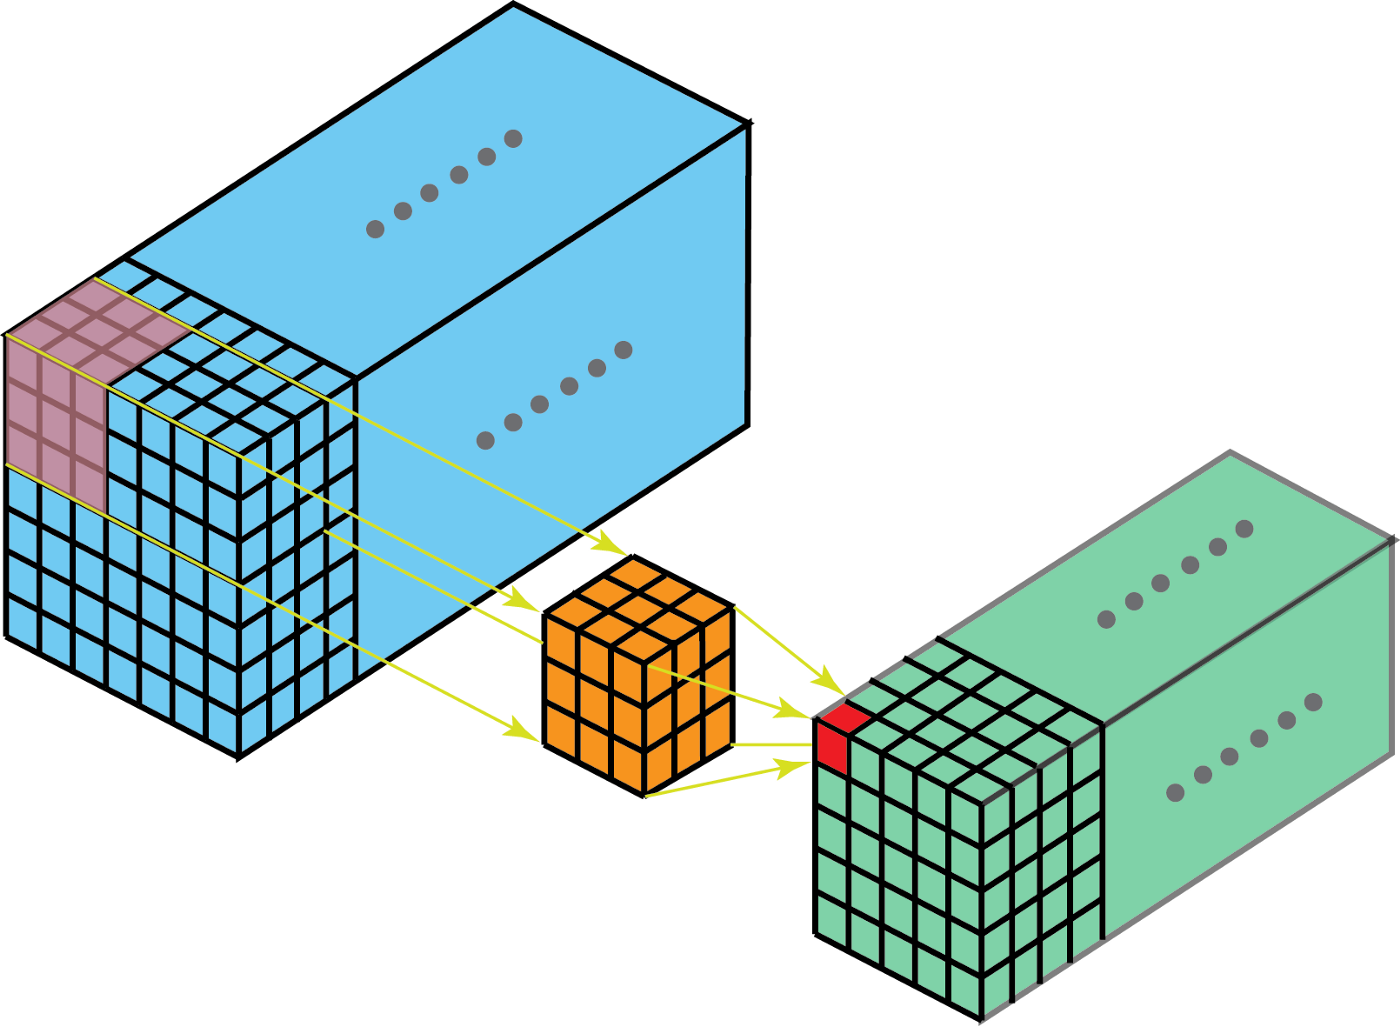

 We have seen that 2D convolution is done on 3D volumetric data. The filter depth is same as the input layer depth. The 3D filter moves only in 2-direction (height & width of the image). The output of such operation is a 2D image (with 1 channel only).

 Here in 3D convolution, the filter depth is smaller than the input layer depth (kernel size < channel size). As a result, the 3D filter can move in all 3-direction (height, width, channel of the image). At each position, the element-wise multiplication and addition provide one number. Since the filter slides through a 3D space, the output numbers are arranged in a 3D space as well. The output is then a 3D data.

3D data generally is a misnomer. They are composed of voxels and can be characterized as having channels [N, H, W, D] where N is the number of channels and height, width and depth are the dimensions of the volume.